# Tardiness

- Tardiness = 0, wenn der Auftrag rechtzeitig oder sogar vorzeitig fertiggestellt wurde.
- Tardiness > 0, wenn der Auftrag später fertiggestellt wird als ursprünglich vorgesehen
- berücksichtigt nur positive Abweichungen, also nur tatsächliche Verspätungen.

$$
T_j = \max(0,\; C_j - d_j)
$$


- $T_j$: Tardiness (Verspätung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $T_j > 0$: Job ist **verspätet**  
- $T_j = 0$: Job ist **pünktlich oder zu früh**  
- Frühfertigungen werden **nicht bestraft**, sondern zu $0$ gesetzt

In [4]:
max_time = 60 * 60 * 1 # 1 h

In [5]:
import time

In [6]:
import math
import pulp
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 11)

In [7]:
import utils.presenter as show
import utils.checker as check

import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [8]:
import utils.scheduling_solver as ssv

In [9]:
df_instance= pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 1, u_b_mmax= 0.96)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
185,Job_018,5,M9,76
186,Job_018,6,M5,47
187,Job_018,7,M3,52
188,Job_018,8,M4,90


In [10]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0)
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,948
1,Job_001,82.55,1307
2,Job_002,143.24,1507
3,Job_003,194.98,1767
4,Job_004,231.20,1175
...,...,...,...
14,Job_014,1116.49,2689
15,Job_015,1122.49,2066
16,Job_016,1123.83,2487
17,Job_017,1241.32,2190


In [11]:
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

,Job,Arrival,Deadline
0,Job_000,0,948
1,Job_001,82,1307
2,Job_002,143,1507
3,Job_003,194,1767
4,Job_004,231,1175
...,...,...,...
14,Job_014,1116,2689
15,Job_015,1122,2066
16,Job_016,1123,2487
17,Job_017,1241,2190


In [12]:
#df_times["Arrival"] = np.floor(df_times["Arrival"] * 120).astype(int)
#df_times["Deadline"] = np.ceil(df_times["Deadline"] * 120).astype(int)
#df_jssp["Processing Time"] = np.round(df_jssp["Processing Time"] * 120).astype(int)
#df_times

## a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$  
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**  
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [15]:
from ortools.sat.python import cp_model
import pandas as pd

def has_solution(solver, any_var):
    try:
        _ = solver.Value(any_var)
        return True
    except:
        return False

def solve_cp_jssp_sum_tardiness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, 
                                 sort_ascending: bool = False, msg: bool = False, timeLimit: int = 3600, gapRel: float = 0.0) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Sortiere nach Deadline, falls gewünscht
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Gruppiere Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # Variablen definieren
    starts, ends, intervals = {}, {}, {}
    tardiness_vars = []

    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o, (op_id, m, d) in enumerate(seq):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Tardiness und Nebenbedingungen pro Job
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.Add(tardiness >= job_end - deadline[job])
        tardiness_vars.append(tardiness)

        # Arrival-Bedingung
        model.Add(starts[(j, 0)] >= arrival[job])

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # Maschinenkonflikte (NoOverlap)
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion: Summe der Tardiness
    model.Minimize(sum(tardiness_vars))

    # Solver
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # Ergebnisse
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE, cp_model.UNKNOWN]:
        if has_solution(solver, next(iter(starts.values()))):
            for j, job in enumerate(jobs):
                for o, (op_id, m, d) in enumerate(all_ops[j]):
                    st = solver.Value(starts[(j, o)])
                    ed = st + d
                    records.append({
                        "Job": job,
                        "Operation": op_id,
                        "Arrival": arrival[job],
                        "Deadline": deadline[job],
                        "Machine": m,
                        "Start": st,
                        "Processing Time": d,
                        "End": ed,
                        "Tardiness": max(0, ed - deadline[job])
                    })

            df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
        else:
            print("No solution was found within the time limit!")
            df_schedule = pd.DataFrame()
    else:
        df_schedule = pd.DataFrame()

    print(f"\nSolver-Status: {solver.StatusName(status)}")
    if records:
        print(f"Summe Tardiness     : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound: {solver.BestObjectiveBound()}")
    print(f"Laufzeit            : {solver.WallTime():.2f} Sekunden")              
 
    return df_schedule


In [16]:
starting_time = time.time()

# Scheduling
df_plan_sum_t = solve_cp_jssp_sum_tardiness(df_jssp, df_times, msg = False, timeLimit=max_time)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_t


Solver-Status: OPTIMAL
Summe Tardiness     : 0.0
Best Objective Bound: 0.0
Laufzeit            : 1.19 Sekunden

Scheduling-Dauer: 0 Minuten und 1.70 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0,948,M0,0,29,29,0
1,Job_000,1,0,948,M1,29,78,107,0
2,Job_001,0,82,1307,M0,82,43,125,0
3,Job_000,2,0,948,M2,107,9,116,0
4,Job_000,3,0,948,M3,116,36,152,0
...,...,...,...,...,...,...,...,...,...
185,Job_016,8,1123,2487,M9,1991,45,2036,0
186,Job_018,9,1340,2636,M7,1992,45,2037,0
187,Job_012,9,940,2165,M8,2020,30,2050,0
188,Job_016,9,1123,2487,M4,2036,33,2069,0


In [17]:
#df_plan_sum_t["Arrival"] = (df_plan_sum_t["Arrival"] / 120).round(2)
#df_plan_sum_t["Deadline"] = (df_plan_sum_t["Deadline"] / 120).round(2)
#df_plan_sum_t["Processing Time"] = (df_plan_sum_t["Processing Time"] / 120).round(2)
#df_plan_sum_t

In [18]:
show.count_column_grouped(df_plan_sum_t, 'Tardiness')

<0             0
0            190
0-30           0
30-60          0
60-120         0
120-240        0
240-480        0
480-720        0
720-1440       0
1440-2880      0
>2880          0
dtype: int32

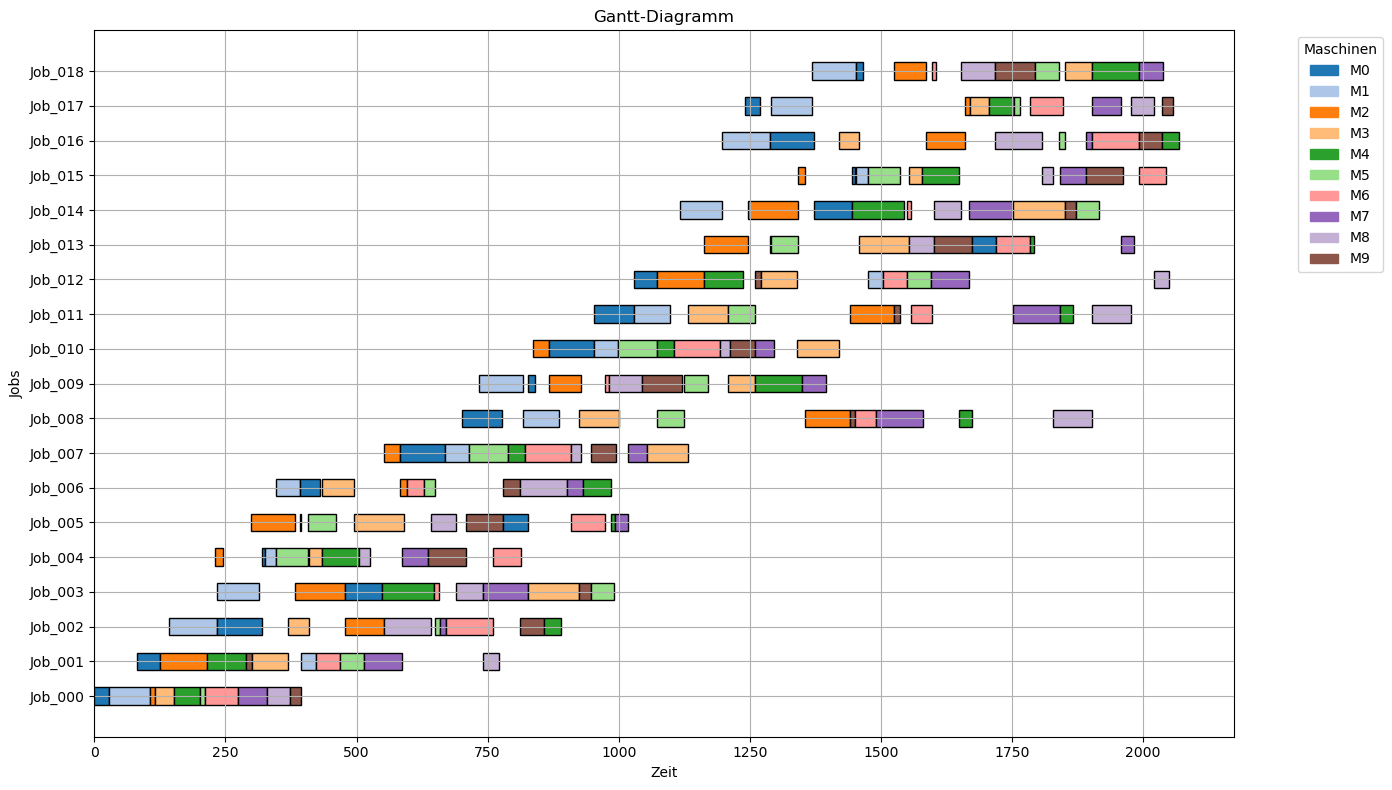

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [19]:
df_plan = df_plan_sum_t

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$  
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**  
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.


In [22]:
from ortools.sat.python import cp_model
import pandas as pd

def has_solution(solver, any_var):
    try:
        _ = solver.Value(any_var)
        return True
    except:
        return False

def solve_cp_jssp_max_tardiness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, 
                                 sort_ascending: bool = False, msg: bool = False, timeLimit: int = 3600, gapRel: float = 0.0) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Sortiere nach Deadline, falls gewünscht
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Gruppiere Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # Variablen definieren
    starts, ends, intervals = {}, {}, {}
    tardiness_vars = []

    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o, (op_id, m, d) in enumerate(seq):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Max-Tardiness-Variable
    max_tardiness = model.NewIntVar(0, horizon, "max_tardiness")

    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.Add(tardiness >= job_end - deadline[job])
        model.Add(max_tardiness >= tardiness)
        tardiness_vars.append(tardiness)

        # Arrival-Bedingung
        model.Add(starts[(j, 0)] >= arrival[job])

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # Maschinenkonflikte (NoOverlap)
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion: max Tardiness
    model.Minimize(max_tardiness)

    # Solver
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # Ergebnisse
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE, cp_model.UNKNOWN]:
        if has_solution(solver, next(iter(starts.values()))):
            for j, job in enumerate(jobs):
                for o, (op_id, m, d) in enumerate(all_ops[j]):
                    st = solver.Value(starts[(j, o)])
                    ed = st + d
                    records.append({
                        "Job": job,
                        "Operation": op_id,
                        "Arrival": arrival[job],
                        "Deadline": deadline[job],
                        "Machine": m,
                        "Start": st,
                        "Processing Time": d,
                        "End": ed,
                        "Tardiness": max(0, ed - deadline[job])
                    })

            df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
        else:
            print("No solution was found within the time limit!")
            df_schedule = pd.DataFrame()
    else:
        df_schedule = pd.DataFrame()

    print(f"\nSolver-Status: {solver.StatusName(status)}")
    if records:
        print(f"Maximale Tardiness : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound: {solver.BestObjectiveBound()}")
    print(f"Laufzeit            : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [23]:
starting_time = time.time()

# Scheduling
df_plan_max_t = solve_cp_jssp_max_tardiness(df_jssp, df_times, msg=False, timeLimit=max_time, gapRel= 0.0)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_max_t


Solver-Status: OPTIMAL
Maximale Tardiness : 0.0
Best Objective Bound: 0.0
Laufzeit            : 1.13 Sekunden

Scheduling-Dauer: 0 Minuten und 1.56 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_000,0,0,948,M0,0,29,29,0
1,Job_000,1,0,948,M1,29,78,107,0
2,Job_001,0,82,1307,M0,82,43,125,0
3,Job_000,2,0,948,M2,107,9,116,0
4,Job_000,3,0,948,M3,116,36,152,0
...,...,...,...,...,...,...,...,...,...
185,Job_016,8,1123,2487,M9,1991,45,2036,0
186,Job_018,9,1340,2636,M7,1992,45,2037,0
187,Job_012,9,940,2165,M8,2020,30,2050,0
188,Job_016,9,1123,2487,M4,2036,33,2069,0


In [24]:
show.count_column_grouped(df_plan_max_t, 'Tardiness')

<0             0
0            190
0-30           0
30-60          0
60-120         0
120-240        0
240-480        0
480-720        0
720-1440       0
1440-2880      0
>2880          0
dtype: int32

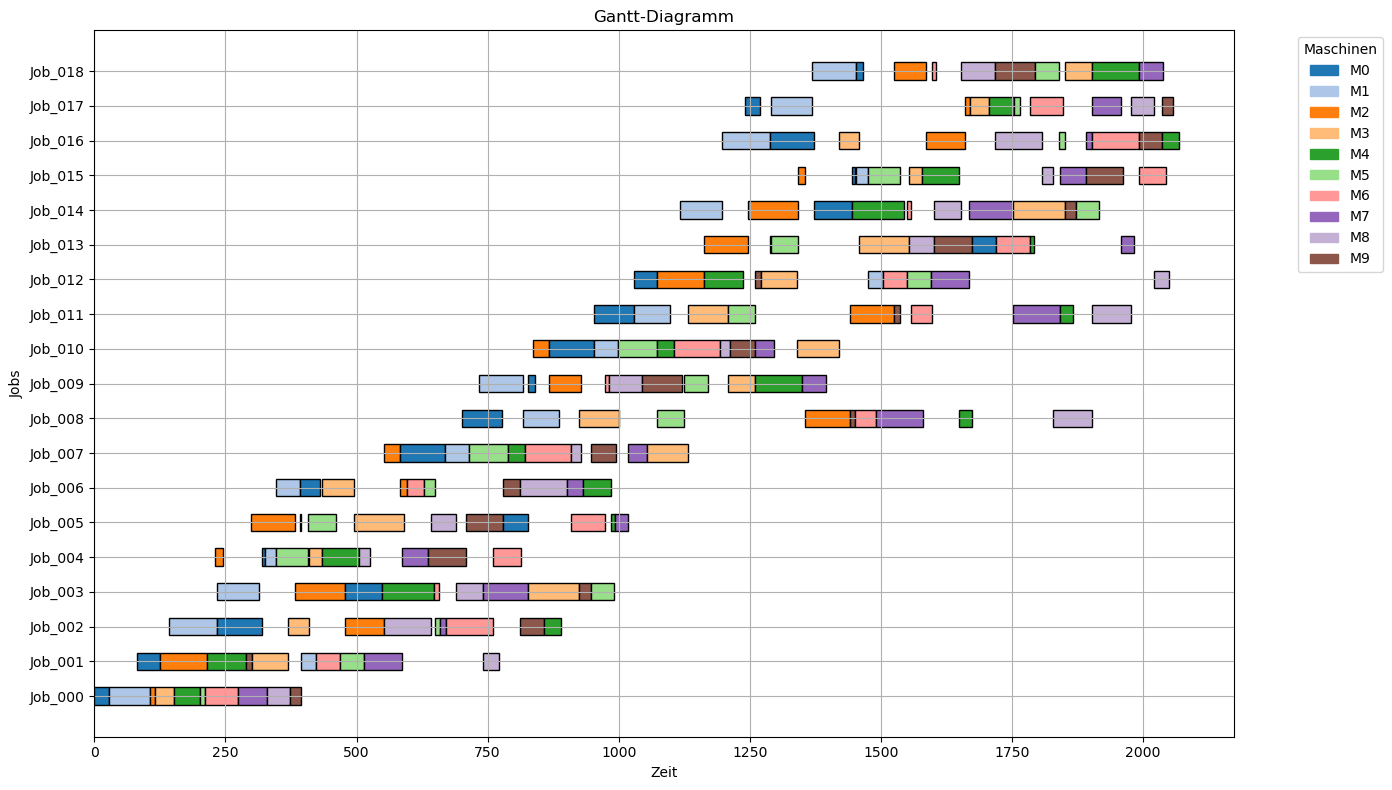

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [25]:
df_plan = df_plan_max_t

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)